# Perform Classification on the ADNI dataset using Adaboost:

## Importing stuff:

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt
import seaborn as sns

## Read the Data:

In [2]:
# Read the data transformed through the Regressional Analysis:
lr_data = pd.read_pickle("./DATA/Linearly_Transformed_Unique_Dataset.pkl")
print(lr_data.shape)
lr_data.head()

(1302, 209)


,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,...,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358,Diagnosis_nearest_2.0_cat
0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,-401.428503,...,1,1,1,0,0,0,0,0,1,0
9,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,596.355045,...,0,1,1,0,1,0,0,0,0,0
24,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,224.874560,...,0,0,0,0,1,0,0,0,0,0
31,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,2633.277779,...,0,0,0,1,1,0,0,0,2,1
45,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,256.289641,...,0,0,0,1,1,0,0,0,1,2


In [3]:
famd_data = pd.read_pickle("./DATA/FAMD_Transformed_data_10_components.pkl")

# Create a new dataset and drop the imaging and genetic data:
c = list(lr_data.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]
columns_to_drop = MRI_columns + genetic_columns
famd = lr_data.drop(labels = columns_to_drop, axis=1)
famd.reset_index(drop=True, inplace=True)

# Embed them into the new dataset:
component_labels = ["component_"+str(x+1) for x in range(famd_data.shape[1])] 
famd[component_labels] = famd_data
print(famd.shape)
famd.head()

(1302, 20)


,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,Diagnosis_nearest_2.0_cat,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,0,-0.458673,1.143940,0.369591,0.425444,0.101996,-0.242310,-0.701120,0.765097,-0.738804,0.042415
1,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,0,-0.622756,0.482209,0.368354,-0.885482,-0.010316,0.286794,-0.638157,-0.230064,0.479634,0.814648
2,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,0,-0.727217,1.565719,-0.007184,1.322716,0.541310,-0.140498,-0.092048,-0.171165,0.532268,0.454948
3,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,1,2.069075,-1.834512,-0.820479,-0.797120,-0.085055,0.544391,-0.176066,-0.842612,0.301969,-0.082777
4,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,2,0.702876,0.594002,0.242167,0.216200,0.604157,0.349324,-0.409264,-0.193592,0.124446,0.274540


## Defining helper functions:

In [4]:
def perform_classification(X_train, X_test, Y_train, Y_test, model, params):
    # Performing Grid Search and Cross Validation in order to find the best combination of parameters:
    clf = GridSearchCV(model, params, n_jobs=-1, cv=5)
    clf.fit(X_train,Y_train)
    # Finding the best classifier's prediction, and then computing the metrics. 
    pred =  clf.predict(X_test)
    acc = accuracy_score(Y_test, pred)
    f1 = f1_score(Y_test, pred, average='weighted')
    cm = confusion_matrix(Y_test, pred, normalize='true')
    bal_acc = balanced_accuracy_score(Y_test, pred)
    print("Best Parameters:",clf.best_params_)
    return acc, f1, bal_acc, np.around(cm, decimals=2), clf.best_params_

def barplot_scores(Accuracies, F1s, Bal_Accuracies, Names):
    barWidth = 0.2
    fig = plt.subplots(figsize =(14, 8), dpi=600)
    
    br1 = np.arange(len(Accuracies))
    br2 = [x + barWidth for x in br1] 
    br3 = [x + barWidth for x in br2] 
    
    plt.bar(br1, [100*x for x in Accuracies], color ='r', width = barWidth, edgecolor ='grey', label ='Accuracy')
    plt.bar(br2, [100*x for x in F1s], color ='b', width = barWidth, edgecolor ='grey', label ='F1 score')
    plt.bar(br3, [100*x for x in Bal_Accuracies], color ='g', width = barWidth, edgecolor ='grey', label ='Balanced Accuracy')
    
    plt.xlabel('SVM', fontweight ='bold', fontsize = 15)
    plt.ylabel('Accuracy Score (%)', fontweight ='bold', fontsize = 15)
    
    plt.xticks([r + barWidth for r in range(len(Accuracies))],Names, rotation=45)
    plt.grid()
    plt.legend(prop={'size': 7})
    plt.show()
    return

def confusion_matrices(Confusion_Matrices, names, n_rows=2, n_cols=3):
    fig, axes = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(22,22));
    sns.set(font_scale=1) # for label size
    
    # No DCCA:
    for i in range(len(names)):
        row, col = i // n_cols, i % n_cols
        ytick = False
        xtick = False

        if col == 0:
            ytick = ["CN", "AD", "MCI"]
        if row == n_rows - 1:
            xtick = ["CN", "AD", "MCI"]
            
        sns.heatmap(Confusion_Matrices[i], annot=True, annot_kws={"size": 16}, ax = axes[row][col], fmt='g',
                   xticklabels = xtick, yticklabels = ytick).set_title(names[i])
            
    plt.show()
    return

def undersample(df, ylabel='Diagnosis_nearest_2.0'):
    classes = df[ylabel].value_counts().to_dict() # specific to this dataset
    least_class_amount = min(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df[ylabel] == key]) 
    classes_sample = []
    for i in range(0,len(classes_list)-1):
        classes_sample.append(classes_list[i].sample(least_class_amount))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[-1]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

## Perform Classification using Bagging:

In [5]:
# Defining the AdaBoostClassifier model, as well as the model parameters for the Grid Search:
model1 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=1.0)
params1 = {
    'n_estimators': [5, 10, 15, 50],
    'algorithm': ['SAMME.R','SAMME'],
    'base_estimator__criterion': ["gini", "entropy"],    
    'base_estimator__max_depth': [1,2,5]
}
model2 = AdaBoostClassifier(base_estimator=LinearSVC(), learning_rate=1.0)
params2 = {
    'n_estimators': [5, 10, 15, 50],
    'algorithm': ['SAMME.R','SAMME'],
    'base_estimator__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
}


# The different trial names (for saving the best parameters if needed):
names = ['Both without DCCA DT',
         'Both without DCCA SVM']

# Saving the metrics and the Confusion Matrices, as well as the best parameter combinations:
Accuracies = []
F1s = []
Balanced_Accuracies = []
Confusion_Matrices = []
Best_parameter_combinations = []

##############################################################################  FAMD IMAGING + GENETIC without DCCA:
print("#################### IMAGING + GENETIC: ####################")
# Get the values that interest us:
X = famd[component_labels]
Y = famd["Diagnosis_nearest_2.0_cat"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False, random_state=42)

acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model1, params1)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model2, params2)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)


Trial_info = []
for i in range(len(names)):
    Trial_info.append([Accuracies[i],
                       Balanced_Accuracies[i],
                       Confusion_Matrices[i],
                       Best_parameter_combinations[i]])
print(Trial_info)

max_acc = np.argmax(Accuracies)
print("Model with max Accuracy: ", names[max_acc], " with an Accuracy score of ", round(max(Accuracies)*100,3))
max_f1 = np.argmax(F1s)
print("Model with max F1 Score: ", names[max_f1], " with an F1 Score of ", round(max(F1s)*100,3))
max_bal_acc = np.argmax(Balanced_Accuracies)
print("Model with max Balanced Accuracy Score: ", names[max_bal_acc], " with a Balanced Accuracy Score of ", round(max(Balanced_Accuracies)*100,3))

#################### IMAGING + GENETIC: ####################
Best Parameters: {'algorithm': 'SAMME.R', 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'n_estimators': 10}
Best Parameters: {'algorithm': 'SAMME', 'base_estimator__C': 0.01, 'n_estimators': 10}
[[0.5287356321839081, 0.4657442791410633, array([[0.57, 0.02, 0.41],
       [0.17, 0.22, 0.61],
       [0.3 , 0.09, 0.61]]), {'algorithm': 'SAMME.R', 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'n_estimators': 10}], [0.5325670498084292, 0.4598451649428648, array([[0.43, 0.02, 0.54],
       [0.02, 0.26, 0.72],
       [0.22, 0.09, 0.69]]), {'algorithm': 'SAMME', 'base_estimator__C': 0.01, 'n_estimators': 10}]]
Model with max Accuracy:  Both without DCCA SVM  with an Accuracy score of  53.257
Model with max F1 Score:  Both without DCCA SVM  with an F1 Score of  51.831
Model with max Balanced Accuracy Score:  Both without DCCA DT  with a Balanced Accuracy Score of  46.574


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 486, in fit
    return super().fit(X, y, sample_weight)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 132, in fit
    self._validate_estimator()
  File "C:\Users\user\

### Visualizing the results:

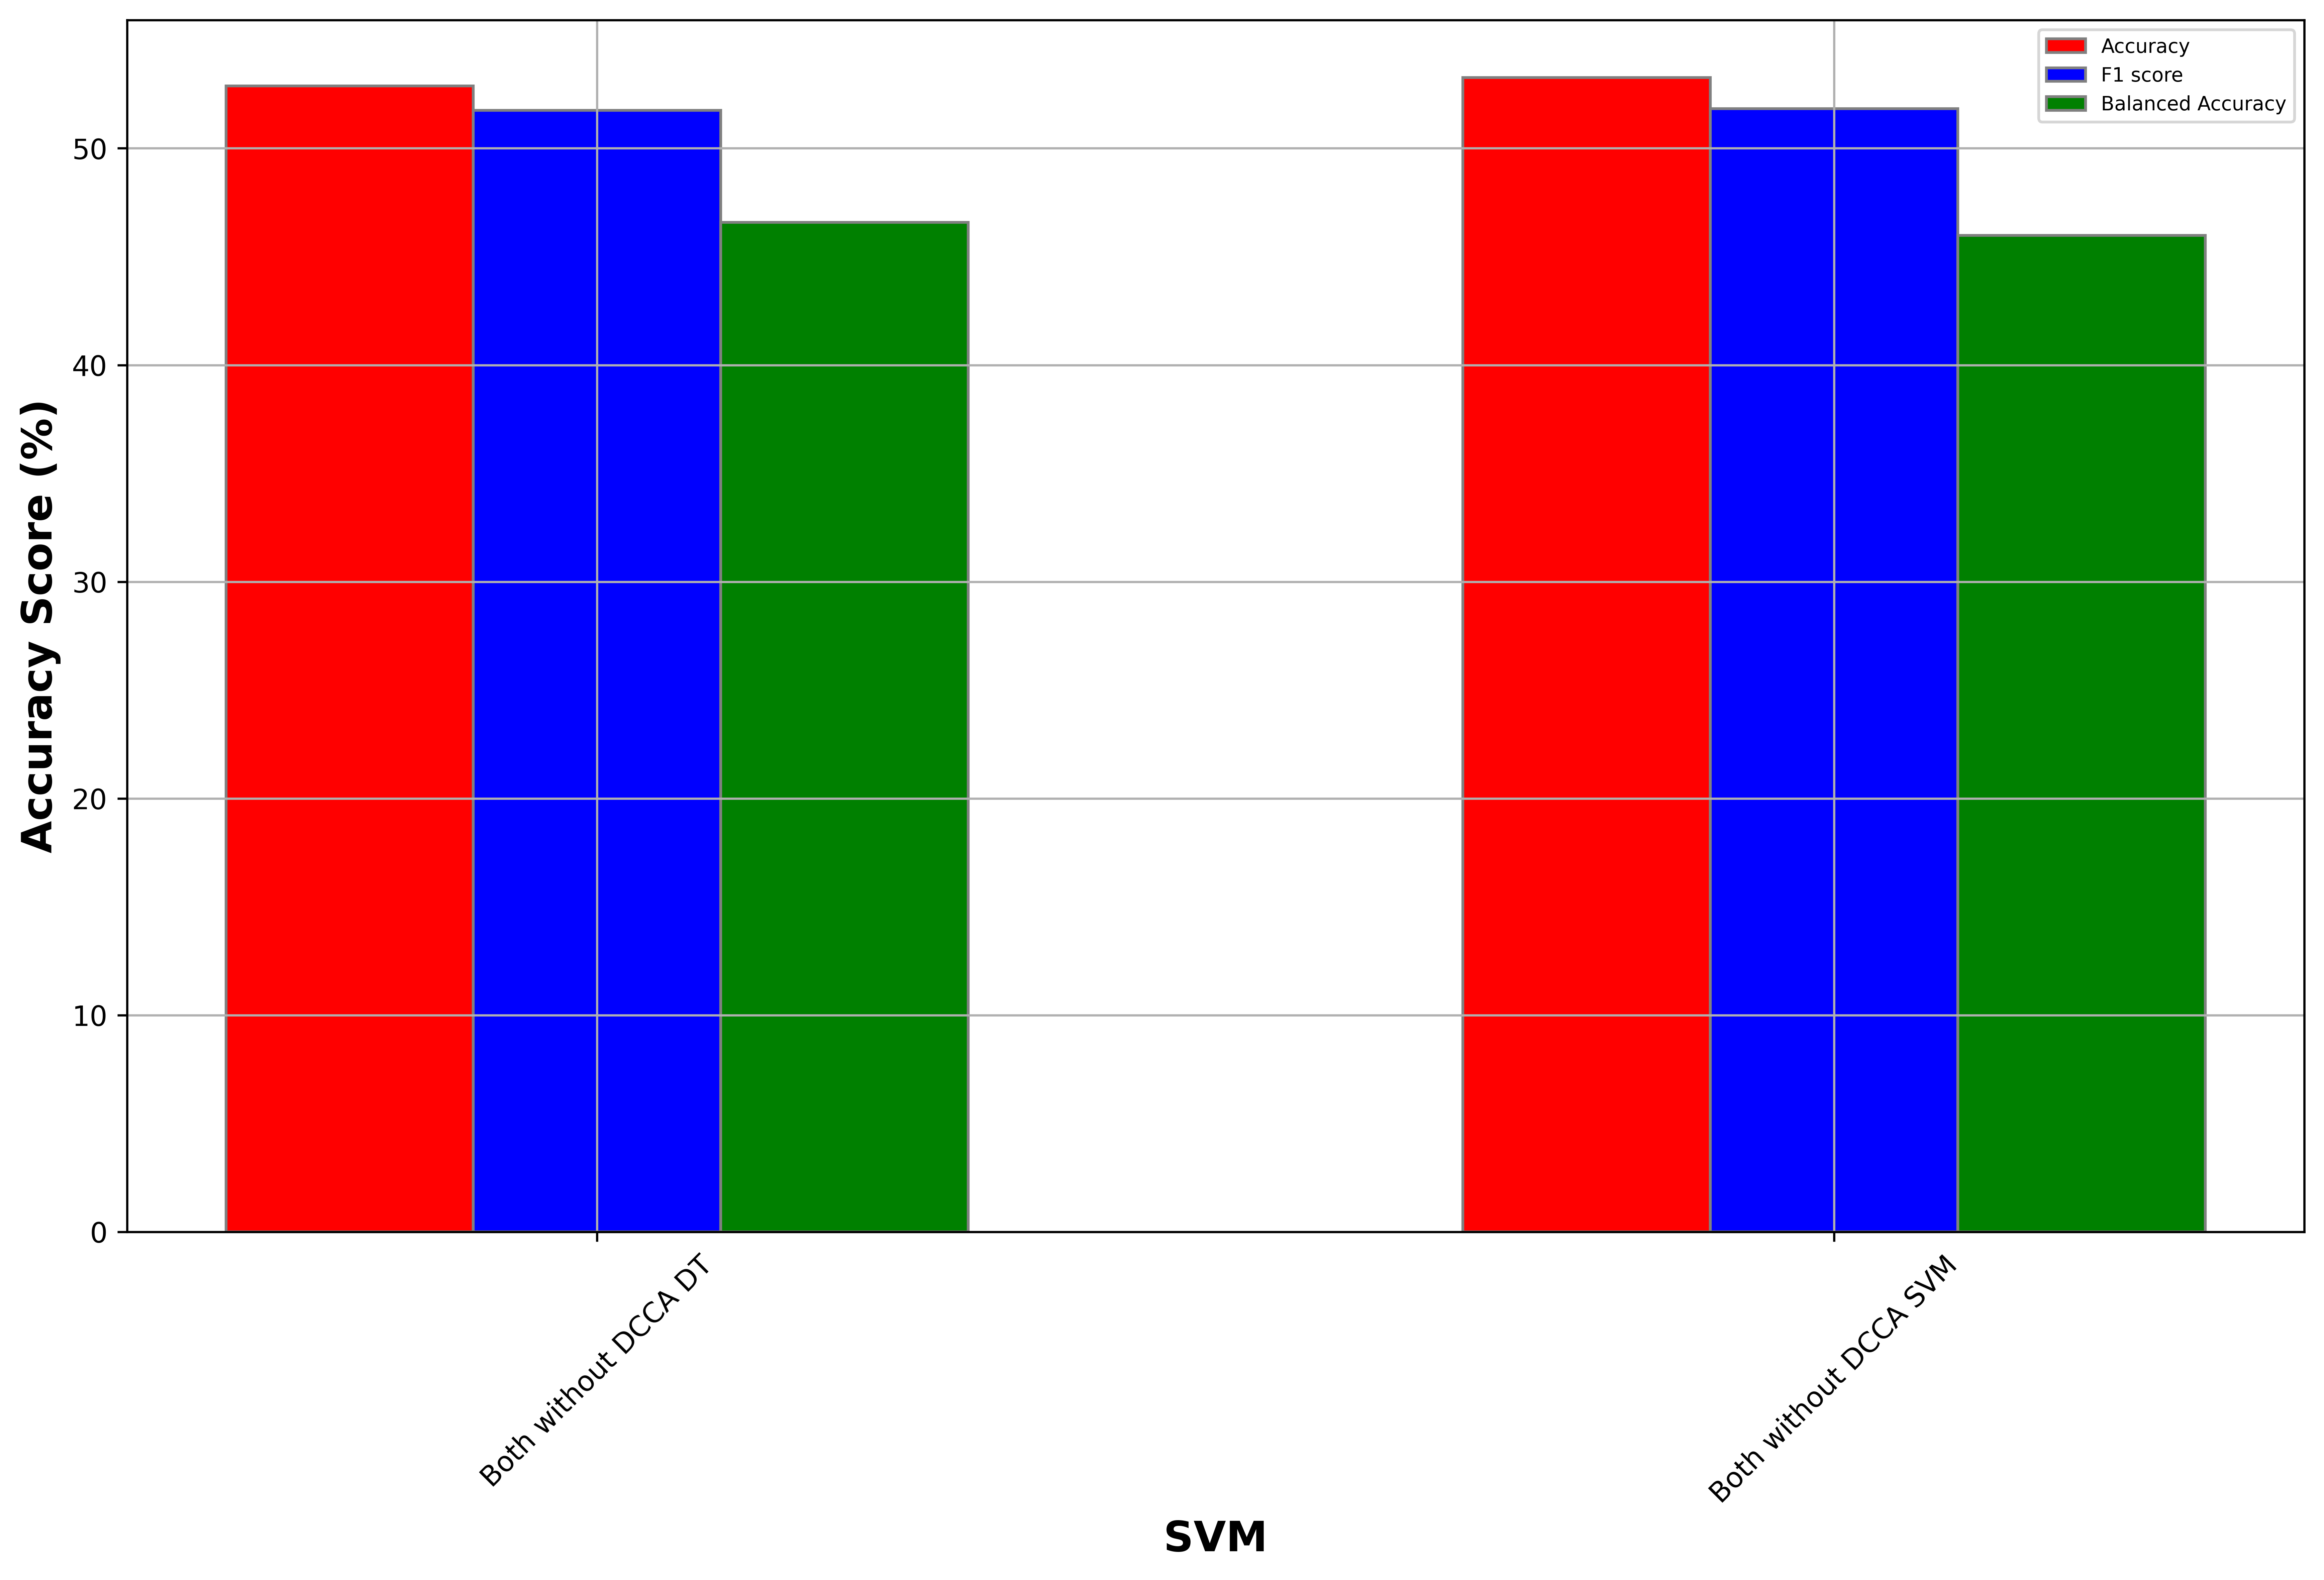

In [6]:
barplot_scores(Accuracies, F1s, Balanced_Accuracies, names)

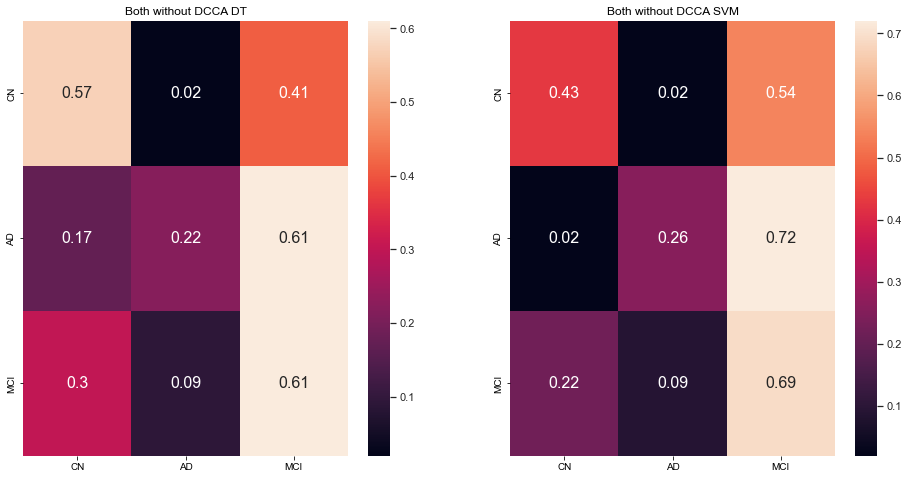

In [7]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(16,8));
sns.set(font_scale=1) # for label size

# No DCCA:
for i in range(len(names)):
    ytick = ["CN", "AD", "MCI"]
    xtick = ["CN", "AD", "MCI"]

    sns.heatmap(Confusion_Matrices[i], annot=True, annot_kws={"size": 16}, ax = axes[i], fmt='g',
               xticklabels = xtick, yticklabels = ytick).set_title(names[i])

plt.show()


##  Scaling and sampling:

In [8]:
# Defining the AdaBoostClassifier model, as well as the model parameters for the Grid Search:
model1 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=1.0)
params1 = {
    'n_estimators': [5, 10, 15, 50],
    'algorithm': ['SAMME.R','SAMME'],
    'base_estimator__criterion': ["gini", "entropy"],    
    'base_estimator__max_depth': [1,2,5]
}
model2 = AdaBoostClassifier(base_estimator=LinearSVC(), learning_rate=1.0)
params2 = {
    'n_estimators': [5, 10, 15, 50],
    'algorithm': ['SAMME.R','SAMME'],
    'base_estimator__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
}


# The different trial names (for saving the best parameters if needed):
names = ['Both without DCCA DT',
         'Both without DCCA SVM']

# Saving the metrics and the Confusion Matrices, as well as the best parameter combinations:
Accuracies = []
F1s = []
Balanced_Accuracies = []
Confusion_Matrices = []
Best_parameter_combinations = []

##############################################################################  FAMD IMAGING + GENETIC without DCCA:
print("#################### IMAGING + GENETIC: ####################")
# Get the values that interest us:
X = famd[component_labels]
Y = famd["Diagnosis_nearest_2.0_cat"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False, random_state=42)

acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model1, params1)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model2, params2)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)


Trial_info = []
for i in range(len(names)):
    Trial_info.append([Accuracies[i],
                       Balanced_Accuracies[i],
                       Confusion_Matrices[i],
                       Best_parameter_combinations[i]])
print(Trial_info)

max_acc = np.argmax(Accuracies)
print("Model with max Accuracy: ", names[max_acc], " with an Accuracy score of ", round(max(Accuracies)*100,3))
max_f1 = np.argmax(F1s)
print("Model with max F1 Score: ", names[max_f1], " with an F1 Score of ", round(max(F1s)*100,3))
max_bal_acc = np.argmax(Balanced_Accuracies)
print("Model with max Balanced Accuracy Score: ", names[max_bal_acc], " with a Balanced Accuracy Score of ", round(max(Balanced_Accuracies)*100,3))

#################### IMAGING + GENETIC: ####################
Best Parameters: {'algorithm': 'SAMME.R', 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'n_estimators': 10}
Best Parameters: {'algorithm': 'SAMME', 'base_estimator__C': 0.01, 'n_estimators': 10}
[[0.5287356321839081, 0.4657442791410633, array([[0.57, 0.02, 0.41],
       [0.17, 0.22, 0.61],
       [0.3 , 0.09, 0.61]]), {'algorithm': 'SAMME.R', 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'n_estimators': 10}], [0.5325670498084292, 0.4598451649428648, array([[0.43, 0.02, 0.54],
       [0.02, 0.26, 0.72],
       [0.22, 0.09, 0.69]]), {'algorithm': 'SAMME', 'base_estimator__C': 0.01, 'n_estimators': 10}]]
Model with max Accuracy:  Both without DCCA SVM  with an Accuracy score of  53.257
Model with max F1 Score:  Both without DCCA SVM  with an F1 Score of  51.831
Model with max Balanced Accuracy Score:  Both without DCCA DT  with a Balanced Accuracy Score of  46.574


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 486, in fit
    return super().fit(X, y, sample_weight)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 132, in fit
    self._validate_estimator()
  File "C:\Users\user\

### Visualizing the results:

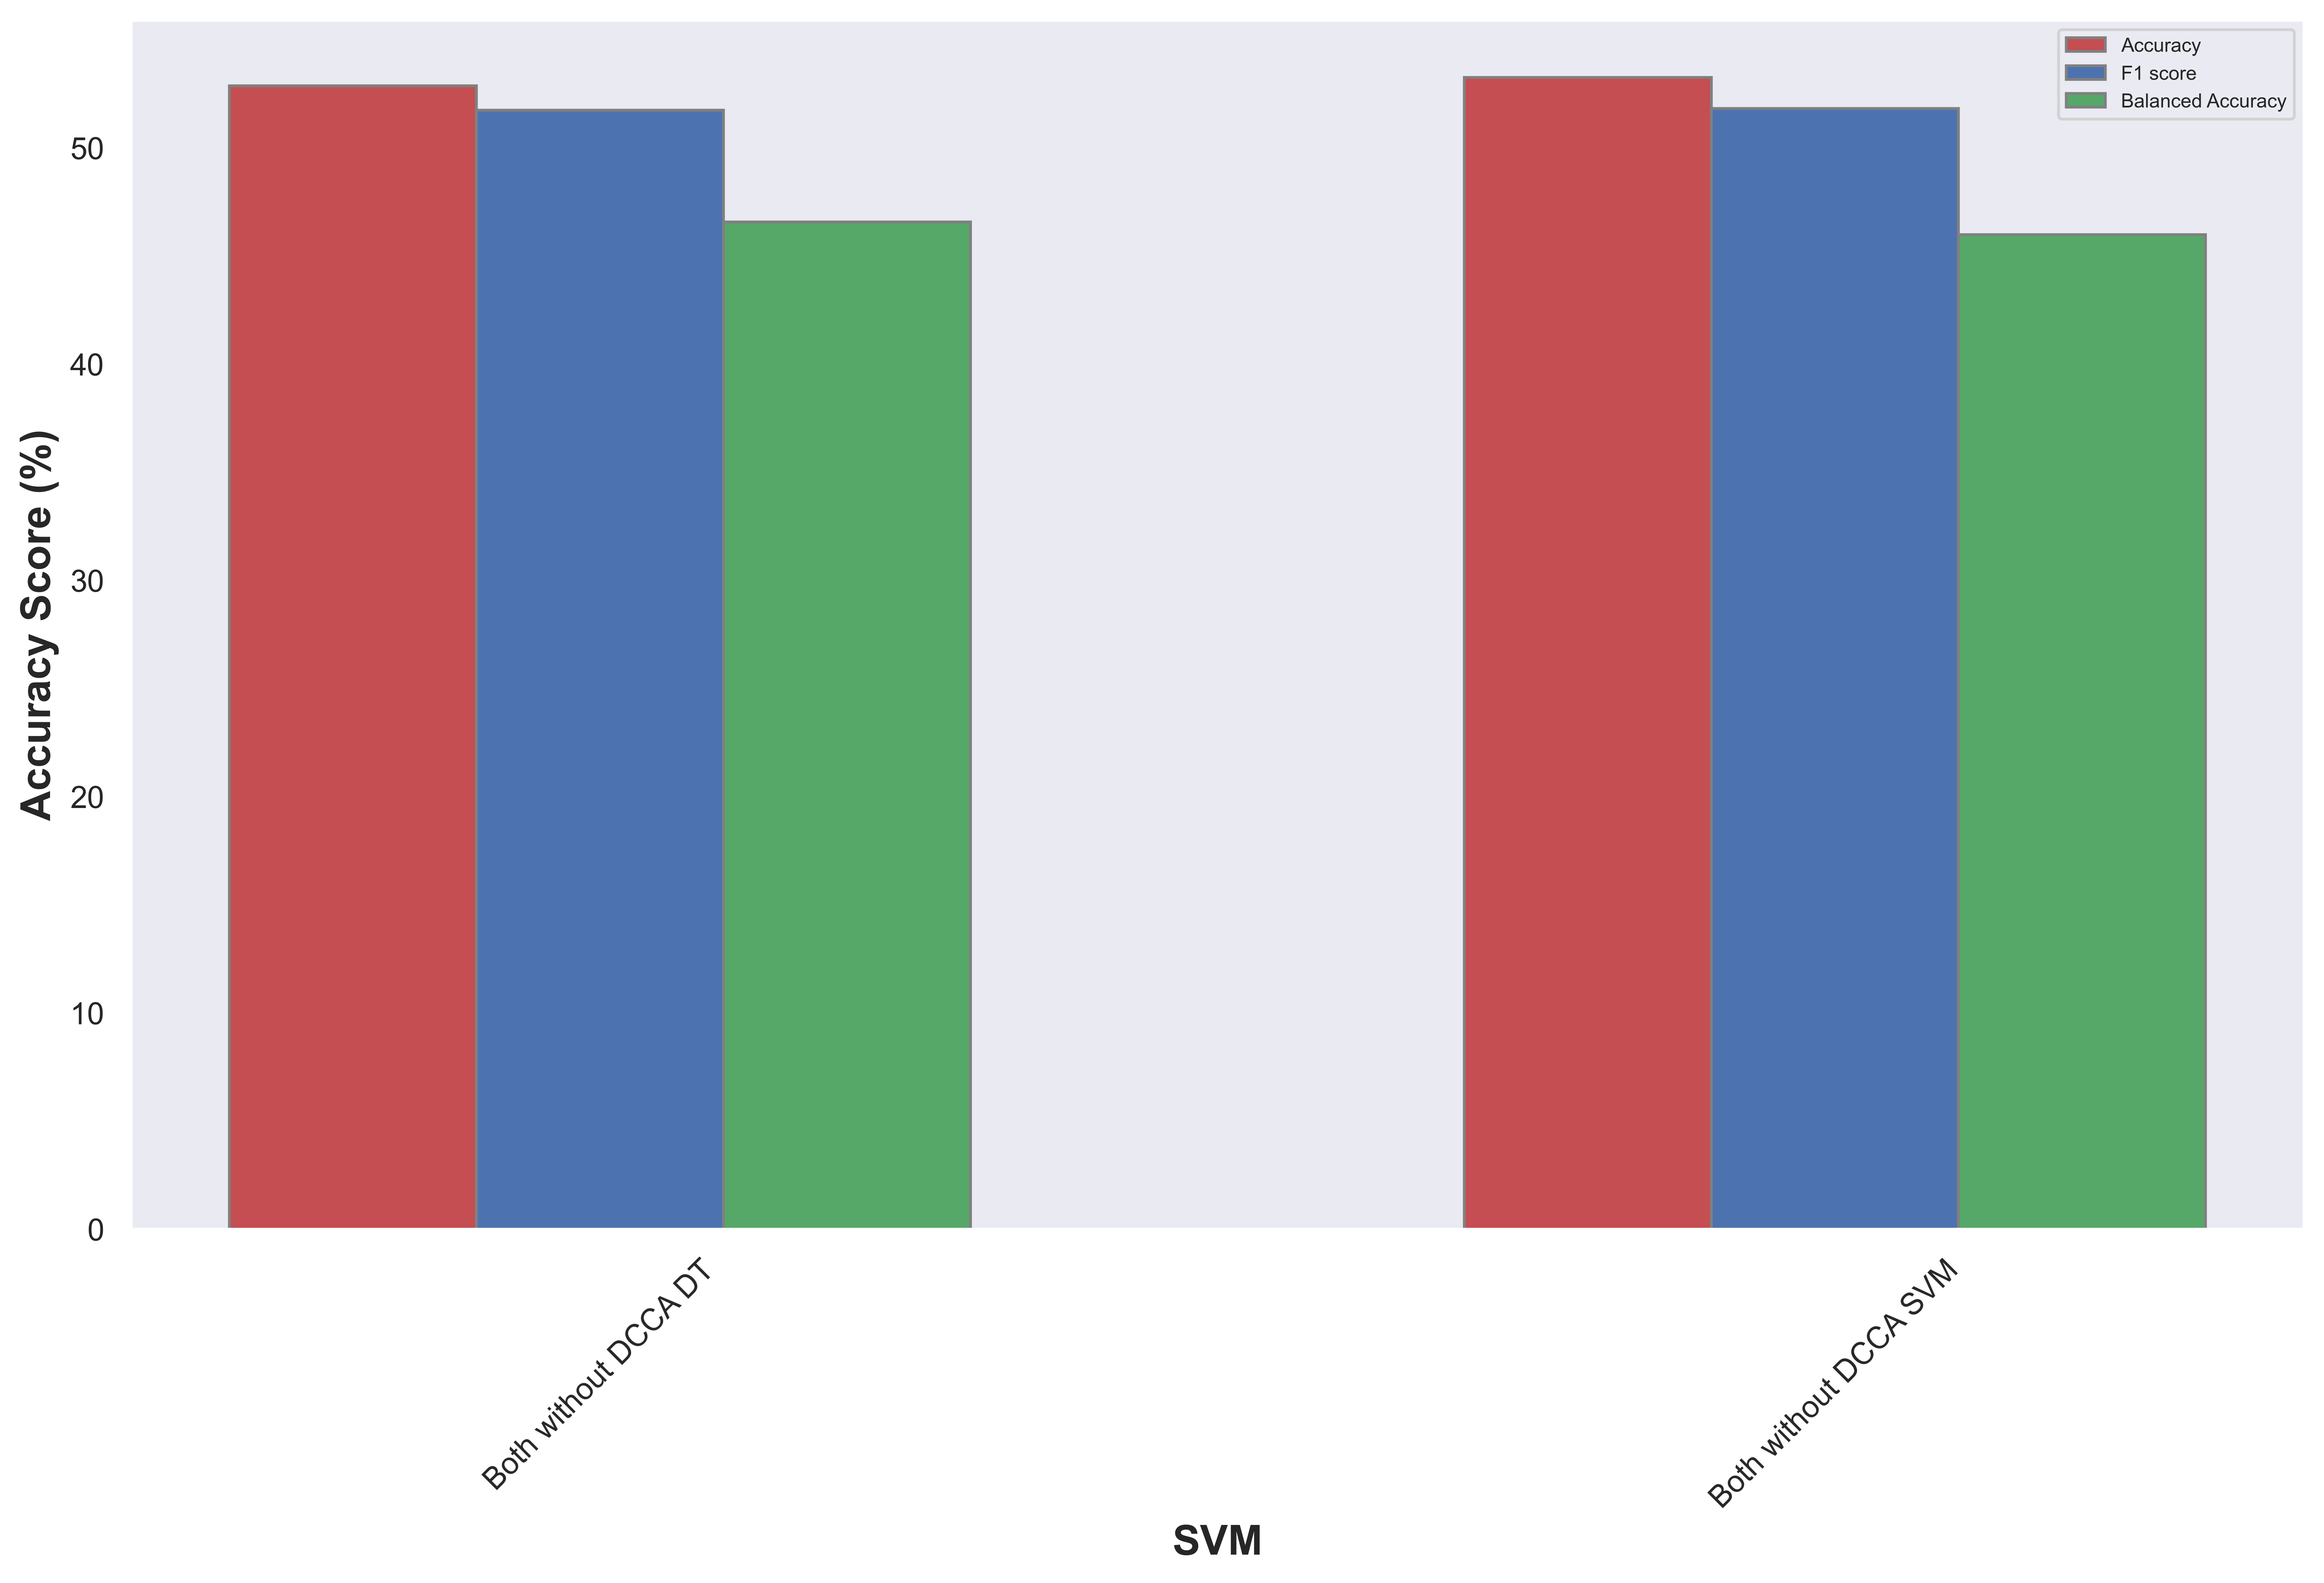

In [9]:
barplot_scores(Accuracies, F1s, Balanced_Accuracies, names)

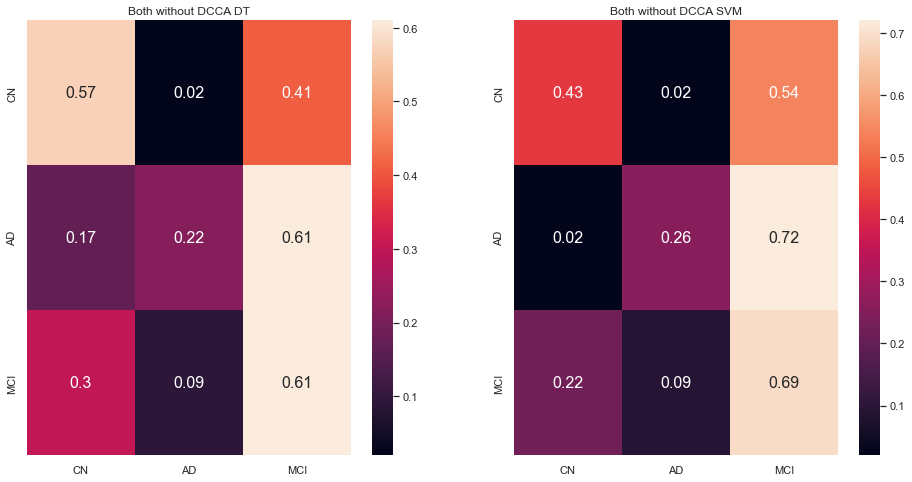

In [10]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(16,8));
sns.set(font_scale=1) # for label size

# No DCCA:
for i in range(len(names)):
    ytick = ["CN", "AD", "MCI"]
    xtick = ["CN", "AD", "MCI"]

    sns.heatmap(Confusion_Matrices[i], annot=True, annot_kws={"size": 16}, ax = axes[i], fmt='g',
               xticklabels = xtick, yticklabels = ytick).set_title(names[i])

plt.show()